<a href="https://colab.research.google.com/github/callumhedemann/Reinforcement-Learning/blob/master/q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Q Learning Algorithms

### Tabular SARSA(0): Slippery Frozen Lake 8x8

In [0]:
import gym
import time, random, math
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make('FrozenLake8x8-v0', is_slippery=True)

In [0]:
def rate_policy(env, policy, n_episodes=100):    
    wins = 0
    for _ in range(n_episodes):
        env.reset()
        state = 0
        while True:
            action = np.argmax(policy[state])
            state, reward, done, _ = env.step(action)
            if done:
                if reward==1:
                    wins+=1
                break
    return wins/n_episodes

CPU times: user 3min 17s, sys: 53.7 ms, total: 3min 17s
Wall time: 3min 17s


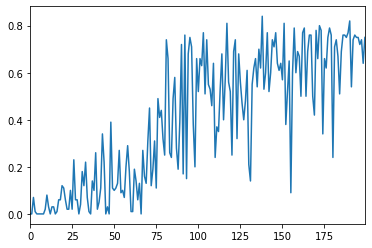

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 1.0, 0.1, 0.9, 0.9, 0.1
n_episodes = 200000
avg_wins = []
# q-learning because action = max(actions)
for n in range(n_episodes):
    env.reset()
    state = 0
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    while True:
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # update operation        
        #if done:
        #    q_values[observation] = np.zeros(env.nA)    
        q_sa = q_values[state, action]
        next_action = np.argmax(q_values[observation]) # off policy because this is a greedy policy action selection        
        q_values[state, action] = q_sa + alpha * (reward + gamma * q_values[observation, next_action] - q_sa)
        state = observation        
        if done: 
            #if reward==1:
            #    print('win')
            break
    if n%1000==0: # diagnostic
        avg_wins.append(rate_policy(env, q_values))        
#env.close()
pd.Series(avg_wins).plot()

### N-step Tabular Sarsa

##### Monte Carlo (high n values) not working currently

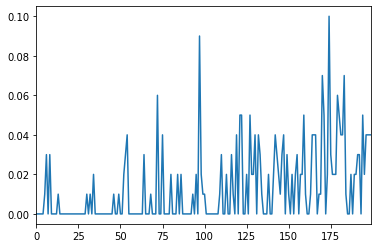

In [0]:
#%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 1.0, 0.1, 0.9, 0.9, 0.1
n_episodes = 200000
avg_wins = []
nstep = 500 # n step sarsa, or n td(n) ??
for n in range(n_episodes):
    env.reset()    
    states, actions, rewards = [0], [], [] # epsiode trajectory    
    t, T = 0, np.inf
    done = False
    win = False
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule       
    while True:
        #alpha, epsilon = 1.0, 0.9
        if not done:
            if (random.random() < epsilon):
                action = env.action_space.sample()
            else:
                action = np.argmax(q_values[states[-1]])
            observation, reward, done, info = env.step(action)
            states.append(observation)
            actions.append(action)
            rewards.append(reward)
            #if reward==1:
                #win=True
        tau = t - nstep + 1
        if win:
            print('states', states[-10:])
            print('actions', actions[-10:])
            print('t,T',t,T)
            print('tau', tau)
        if tau >= 0: # update operation at step tau
            g, gam = 0, 1
            if win:
                print('rewards', rewards[tau:min(tau+nstep,T+1)])
            for r in rewards[tau:min(tau+nstep,T+1)]: # the sample estimate of rewards                
                g += gam*r
                gam *= gamma
            if win:
                print('g sam',g)
            if (tau+nstep) < T:  # the bootstrap estimate of q_s'a'
                g += (gamma**nstep) * q_values[states[tau+nstep], np.argmax(q_values[states[tau+nstep]])]
                if win:
                    print('g bs',g)
            q_sa = q_values[states[tau], actions[tau]]
            q_values[states[tau], actions[tau]] = q_sa + alpha * (g - q_sa)                                   
        if done and T == np.inf:
            T = t
        t+=1
        if win:
            print(q_values)
            print('-------------------\n')    
        if tau >= T:
            break    
    if win:
        sdfsdf
    if n%1000==0: # diagnostic
        avg_wins.append(rate_policy(env, q_values))        
#env.close()
pd.Series(avg_wins).plot()

### 5-step return working but poorly

CPU times: user 3min 11s, sys: 222 ms, total: 3min 12s
Wall time: 3min 11s


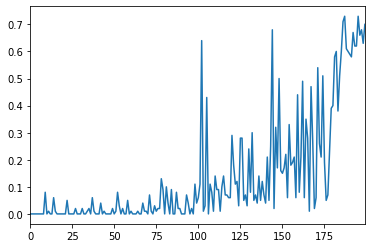

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 1.0, 0.1, 0.9, 0.9, 0.1
n_episodes = 200000
avg_wins = []
nstep = 5 # n step sarsa, or n td(n) ??
for n in range(n_episodes):
    env.reset()
    state = 0
    states,actions,rewards = [0], [], [] # epsiode trajectory    
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    while True:
        #alpha, epsilon = 1.0, 0.9
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        states.append(observation)        
        actions.append(action)
        rewards.append(reward)        
        if len(states)>nstep: # update operation        
            g, gam = 0, 1
            for r in rewards[-nstep:]: # the sample estimate of rewards
                g += gam*r
                gam *= gamma            
            g += (gamma ** nstep) * q_values[observation, np.argmax(q_values[observation])] # the bootstrap estimate of q_s`a`            
            q_sa = q_values[states[-(nstep+1)], actions[-nstep]]                    
            q_values[states[-(nstep+1)], actions[-nstep]] = q_sa + alpha * (g - q_sa)
        state = observation                
        if done: # finish remaining updates with trajectory length < nstep
            for i in range(min(nstep,len(states)-1)):
                g, gam = 0, 1
                for r in rewards[-i:]: # the sample estimate of rewards
                    g += gam*r
                    gam *= gamma            
                # no bootstrapping required as full return is known by this point
                q_sa = q_values[states[-(i+1)], actions[-i]]                    
                q_values[states[-(i+1)], actions[-i]] = q_sa + alpha * (g - q_sa)
            #if reward==1:
            #    print('win')                
            break    
    if n%1000==0: # diagnostic
        avg_wins.append(rate_policy(env, q_values))        
#env.close()
pd.Series(avg_wins).plot()

## Eligibility Traces: Lambda Returns

#### TD(lambda=0)

CPU times: user 5min 24s, sys: 71.9 ms, total: 5min 24s
Wall time: 5min 24s


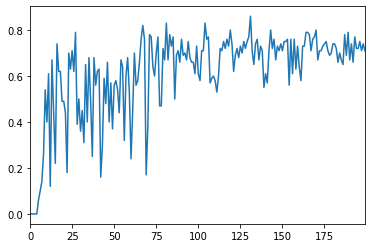

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.1, 0.01, 0.9, 0.9, 0.1
n_episodes = 200000
trace_decay = 0.0 #  0 := TD(0);     1 := Monte Carlo
avg_wins = []
for n in range(n_episodes):
    env.reset()
    state = 0
    traces = np.zeros((env.observation_space.n, env.action_space.n))
    #states, actions = [], []
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    while True:
        #alpha, epsilon = 0.1, 0.9
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # update operation
        traces[state, action] += 1 # or = 1? this choice is called accumulating traces vs replacing traces
        td_error = reward + gamma * q_values[observation, np.argmax(q_values[observation])] - q_values[state, action]        
        #if reward==1:
        #  print('1', td_error)
        # apply q value update as matrix opertion where td_error is broadcast across entire matrix
        q_values += alpha * td_error * traces              
        traces *= gamma * trace_decay        
        #traces[traces<0.01] = 0 # truncate traces (not needed in episodic)
        state = observation
        if done: 
            break
    if n%1000==0: # diagnostic
        avg_wins.append(rate_policy(env, q_values))        
#env.close()
pd.Series(avg_wins).plot()

#### TD(lambda-0.75) is less effective (not working properly)

CPU times: user 4min 46s, sys: 56.9 ms, total: 4min 46s
Wall time: 4min 46s


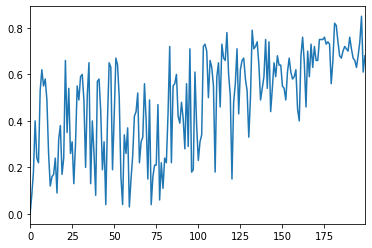

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.1, 0.01, 0.9, 0.9, 0.1
n_episodes = 200000
trace_decay = 0.75 #  0 := TD(0);     1 := Monte Carlo
avg_wins = []
for n in range(n_episodes):
    env.reset()
    state = 0
    traces = np.zeros((env.observation_space.n, env.action_space.n))
    #states, actions = [], []
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    while True:
        #alpha, epsilon = 0.1, 0.9
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # update operation
        #states.append(state)
        #actions.append(action)
        traces[state, action] += 1 # or = 1?
        td_error = reward + gamma * q_values[observation, np.argmax(q_values[observation])] - q_values[state, action]        
        #if reward==1:
        #  print('1', td_error)
        # apply q value update as matrix opertion where td_error is broadcast across entire matrix
        q_values = q_values + alpha * td_error * traces              
        traces = traces * gamma * trace_decay        
        #traces[traces<0.01] = 0 # truncate traces (not needed in episodic)
        state = observation
        if done: 
            if reward==11:
                print('win')
                #print(q_values)
                print('td_error', td_error)  
                print(reward + gamma * q_values[observation, np.argmax(q_values[observation])] - q_values[state, action])
                print('reward',reward)
                print(gamma * q_values[observation, np.argmax(q_values[observation])])
                print('qsa', q_values[state, action])                       
                #print(alpha * td_error)
                #print(alpha * td_error * traces)
                print('---------------------\n')
            break
    if n%1000==0: # diagnostic
        avg_wins.append(rate_policy(env, q_values))        
#env.close()
pd.Series(avg_wins).plot()

## Value Function Approximation

In [0]:
# for state spaces of intractable size

# q is now a function of state and a feature vector w:
# S * R^d -> R

# the prediction objective minimises MSE across the state distribution mew
# MSE aka mean(Value Error) := sum[mew(s) * (v(s) - v_hat(s))] ** 2
# (mew gives the weighted average)
# calculate state distribution as fraction of time spent under s

# optimise using SGD
# choose dimensionality of w (hidden size?)
# update operation:
# w_t+1 = w_t - 1/2 * alpha * grad[v(s) - v_hat(s, w_t)] ** 2
#       = w_t + alpha[v(s) - v_hat(s, w_t)] * grad(v_hat(s, w)_t)
# where grad of v_hat is a vector of partial derivitatives wrt to w

# Interesting and unique to RL:
# v(s) is unknown! 
# optimisation is done against an approximation of v(s), U_t(s) ("supervised")
# and so...  w_t+1 = w_t + alpha[U_t(s) - v_hat(s, w_t)] * grad(v_hat(s, w)_t)
# if U_t is an unbiased estimate of v(s) then it is guaranteed to converge to a local optimum under decreasing alpha

# but how is the approximation U_t(s) learned? it is not, because it is sampled.

# MC estimates of v are unbiased, so convergence is guaranteed

# Bootstrapped estimates have no such guarantees due to biases. 
# Since their estimates depend on w_t they will be biased and will not produce true gradient descent methods
# they only take part of the gradient into account: the part that effects w_t but not the target estimate
# which is why they are called semi-gradient methods
# they do not coverge reliably / robustly
# but fortunately they do in linear cases of w, and are faster learning than true gradient methods, can be online

### Linear Function Approximation

In [0]:
# weight vector and state vector are both of dimensionality d and v(s,w) is the linear combination of their product
# v(s,w) = w^T x(s) = sum(w_i * x_i)
# the features x_i form a set of basis functions that describe the feature space
# and because of the linearity, grad v = x(s)
# and therefore the update is simply w_t+1 = w_t + alpha[U_t - v_hat(s, w)] x(s)

# advantages of linear methods:
# convergence guaranteed
# global optimum or equally good local optimum can be found - or rather a point near it can be converged to

# Linear Semi-gradient TD(0)
# w_t+1 = w_t + alpha * (r + gamma * w^T * x_t+1 - w^T * x_t) * x_t

# an additional challenge of intractably large state spaces is that the next state | a is not given
# and so this must be approximated ?
# MountainCar gives state updates though, as:
# position x_t+1 = x_t + v_t+1
# velocity v_t+1 = v_t + 0.001 * a_t - 0.0025 cos(3x_t)
# where a0 = -1, a1 = 0, a2 = 1

#### Mountain Car with Tile Coding for linear features

CPU times: user 6min 43s, sys: 439 ms, total: 6min 44s
Wall time: 6min 44s


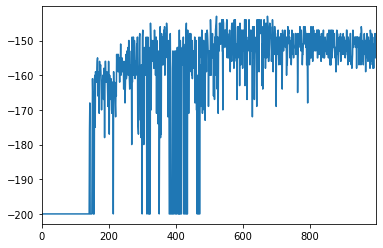

In [0]:
%%time
env = gym.make('MountainCar-v0')
# On-policy episodic semi-gradient one-step sarsa ???

# Linear Semi-gradient TD(0)
# w_t+1 = w_t + alpha * (r + gamma * w^T * x_t+1 - w^T * x_t) * x_t

# only have 2 features to work with?..
# need to create a state function which expands the state space into a latent feature space
# they use 8 grid tiliings (fig 9.9)
# but how does this help without non-linearities?
# note: not solvable with only 2 features directly from state? 
# oh, only true with linear methods

# https://towardsdatascience.com/reinforcement-learning-tile-coding-implementation-7974b600762b

def create_tiling(feat_range, bins, offset):    
    return np.linspace(feat_range[0], feat_range[1], bins+1)[1:-1] + offset
    
def create_tilings(feature_ranges, number_tilings, bins, offsets):
        tilings = []
        # for each tiling
        for tile_i in range(number_tilings):
            tiling_bin = bins[tile_i]
            tiling_offset = offsets[tile_i]
            tiling = []
            # for each feature dimension
            for feat_i in range(len(feature_ranges)):
                feat_range = feature_ranges[feat_i]
                # tiling for 1 feature
                feat_tiling = create_tiling(feat_range, tiling_bin[feat_i], tiling_offset[feat_i])
                tiling.append(feat_tiling)
            tilings.append(tiling)
        return np.array(tilings)

"""
self.state = (position, velocity)
self.min_position = -1.2
self.max_position = 0.6
self.max_speed = 0.07
"""

num_features = 2
feature_ranges = [[-1.2, 0.6], [-0.07, 0.07]] # four dimensional feature space
number_tilings = 8
gs = 8
bins = [[gs, gs], [gs, gs], [gs, gs], [gs, gs],
        [gs, gs], [gs, gs], [gs, gs], [gs, gs]]
#offsets = [[-0.4, -0.1], # use asymettrical offsets
#           [-0.2, -0.05],
#           [0.1, 0.1],
#           [0.3, 0.15],
offsets = [[-0.2, -0.03], # use asymettrical offsets
           [-0.15, -0.02],
           [-0.1, -0.01],
           [-0.05, 0.0],
           [0.05, 0.01], # use asymettrical offsets
           [0.1, 0.02],
           [0.15, 0.03],
           [0.2, 0.04]]

tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)

def get_tile_coding(feature, tilings):
        num_dims = len(feature)
        feat_codings = []
        for tiling in tilings:
            feat_coding = []
            for i in range(num_dims):
                feat_i = feature[i]
                tiling_i = tiling[i]  # tiling on that dimension
                coding_i = np.digitize(feat_i, tiling_i)
                feat_coding.append(coding_i)
            feat_codings.append(feat_coding)
        return np.array(feat_codings)

def features(state):
    coding = get_tile_coding(state, tilings) # number_tilings sets of num_features d coords, 1 for each grid
    #print(coding)
    oh = np.zeros((number_tilings, gs, gs)) # number_tilings gs x gs grids of number_tilings d space    
    for i, row in enumerate(coding):        
        oh[tuple(np.append([i], row))] = 1 # tricky!
    #oh_a = np.zeros(env.action_space.n)
    #oh_a[a] = 1
    #return np.concatenate([oh.flatten(), oh_a])
    return oh.flatten()

# thanks to https://github.com/SamKirkiles/mountain-car-SARSA-AC/blob/master/mountain_car.py
# for pointing out that there is a seperate set of weights for each action
w = np.zeros((env.action_space.n, number_tilings*(gs**num_features)))

def q_value(state, action):
    return np.sum(w[action] * features(state))

# I think you are supposed to approximate the q values as well.
# https://stackoverflow.com/questions/53077399/when-using-functional-approximation-in-reinforcement-learning-how-does-one-selec
# this would mean action would have to be an input to q approx??
# "When choosing what action to select you enter the state and action into the neural net and get back the neural net's approximate values of each action."
alpha_max, alpha_min, epsilon_max, epsilon_min = 0.1, 0.01, 0.1, 0.0
gamma = 0.9
n_episodes = 1000
returns = []
for n in range(n_episodes):
    state = env.reset()
    g = 0
    while True:
        if n < (n_episodes/2):
            #alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
        else:
            #alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min
        #alpha, epsilon = 0.1/number_tilings, 0.1
        alpha = 0.1/number_tilings
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            q_values = np.zeros(env.action_space.n)
            for i in range(env.action_space.n):
                q_values[i] = q_value(state, i)
            action = np.argmax(q_values)
        observation, reward, done, info = env.step(action)
        g += reward
        # update operation
        q_values = np.zeros(env.action_space.n)
        for i in range(env.action_space.n):
            q_values[i] = q_value(observation, i)
        next_action = np.argmax(q_values)        
        w[action] += alpha * (reward + gamma * q_value(observation, next_action) - q_value(state, action)) * features(state) #SGD        
        if done:
            returns.append(g)
            break
        state = observation
pd.Series(returns).plot()

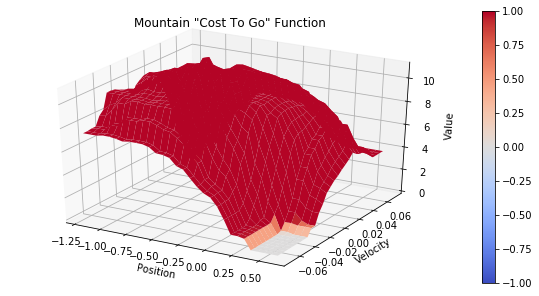

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

def plot_cost_to_go_mountain_car(num_tiles=30):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda s: -np.max([q_value(s,a) for a in range(env.action_space.n)]), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain Car \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()

plot_cost_to_go_mountain_car()

# Go back and change all terminal bootstrapping values to zeros

## Non-linear Function Approximation

### The Deadly Triad: CartPole with ANN for Non-Linear Q function

#### Requires Experience Replay and Double DQN learning to overcome divergence in deadly triad

In [0]:
# the solutions to the q functions for these prolems are all non-linear
# using the raw features from the state to dot product with a weight vector is severely limiting in
# what linear function can be used to approximate the nonlinear q function
# using linear approximation requires feature engineering tricks to approximate these non-linearities with 
# many linear functions
# tile coding provides a mechanism to fit a large number of stepped constant functions
# as the states move through the space, they use an approximation for that immediate local region

# it would be much simpler / effective to just use a non-linear function 
# tile coding, or any other feature engineering methods, requires manual setup, tuning 
# and suffers from all the regular problems of manual feature engineering (suboptimal feature construction)
# and are not really appropriate approximation methods

# so now we just use a simple CNN to perform advanced feature engineering and fit a non-linear q function

episode  0
episode  25
episode  50
episode  75
episode  100
episode  125
episode  150
episode  175
episode  200
episode  225
episode  250
episode  275
episode  300
episode  325
episode  350
episode  375
episode  400
episode  425
episode  450
episode  475
episode  500
episode  525
episode  550
episode  575
episode  600
episode  625
episode  650
episode  675
episode  700
episode  725
episode  750
episode  775
episode  800
episode  825
episode  850
episode  875
episode  900
episode  925
episode  950
episode  975
episode  1000
episode  1025
episode  1050
episode  1075
episode  1100
episode  1125
episode  1150
episode  1175
episode  1200
episode  1225
episode  1250
episode  1275
episode  1300
episode  1325
episode  1350
episode  1375
episode  1400
episode  1425
episode  1450
episode  1475
episode  1500
episode  1525
episode  1550
episode  1575
episode  1600
episode  1625
episode  1650
episode  1675
episode  1700
episode  1725
episode  1750
episode  1775
episode  1800
episode  1825
episode  

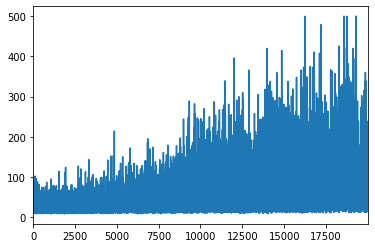

In [0]:
#%%time
# CNN seems to be too hard, try using a shallow NN using the raw state as features, the non linearaity should be able to do what the linear could not with them

# deadly triad??
# https://davidsanwald.github.io/2016/12/11/Double-DQN-interfacing-OpenAi-Gym.html

import gym
import random
import numpy as np
import pandas as pd
env = gym.make('CartPole-v1')
import torch
import torch.nn as nn
import torch.nn.functional as F


class ANN(nn.Module):
    def __init__(self, state_dims=env.observation_space.shape[0], hs=256):
        super(ANN, self).__init__()        
        self.fc1 = nn.Linear(state_dims, hs)
        self.fc2 = nn.Linear(hs, hs)
        self.out = nn.Linear(hs, env.action_space.n) # given a state, outputs a q_value for each action

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = torch.tanh(self.fc1(x)) # https://davidsanwald.github.io/2016/12/11/Double-DQN-interfacing-OpenAi-Gym.html, https://github.com/DavidSanwald/DDQNz
        #x = torch.tanh(self.fc2(x)) # for reals tanh over rulu makes this thing work???
        return self.out(x)

# taken from the pytroch tutorial 
class ReplayBuffer(object): 
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = [*args]
        self.position = (self.position + 1) % self.capacity # overwrite old transitions
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# https://colab.research.google.com/drive/13Q3nTOJY9vYbhg1C0aXXIVM-IQaVVSaU#scrollTo=x--uPzWVHWPU
q_function = ANN().cuda()
q_target = ANN().cuda()
q_target.eval()
#optimiser = torch.optim.RMSprop(q_function.parameters(), lr=0.01)  ########## which one should use??
optimiser = torch.optim.Adam(q_function.parameters(), lr=0.01)
buffer = ReplayBuffer()
alpha_max, alpha_min, epsilon_max, epsilon_min = 0.2, 0.01, 0.9, 0.1
gamma = torch.Tensor([0.9]).cuda()
n_episodes = 20000
bs = 64
target_update = 10
returns, avg_returns, losses = [], [], []
avg_returns_freq = 25

for n in range(n_episodes):
    if n%25==0:
        print('episode ', n)
    state = torch.Tensor(env.reset()).cuda()
    g = 0
    if n%target_update==0:
        q_target.load_state_dict(q_function.state_dict())
    while True:
        #print('g', g)
        if n < (n_episodes/2):
            #alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
        else:
            #alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min        
        
        #alpha = 0.01
        #epsilon = 0.1

        #for param_group in optimiser.param_groups:
        #    param_group['lr'] = alpha
                
        with torch.no_grad():
            q_values = q_function(state.unsqueeze(dim=0))
        
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:          
            action = torch.argmax(q_values.squeeze()).item()         
        
        observation, reward, done, _ = env.step(action)
        observation = torch.Tensor(observation).cuda()        
        
        buffer.push(state, action, reward, observation, 1-int(done)) # sars
        g += reward

        if (len(buffer) >= bs): # and (frame_num%(bs*frame_skip)==0):
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]), torch.Tensor(batch[1]).cuda().long(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]), torch.Tensor(batch[4]).cuda()
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            #actions_mask = torch.zeros((bs,env.action_space.n))
            #actions_mask[np.arange(bs), actions] = 1

            # update operation
            q_values = q_function(states) #.gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            q_pred = q_values.clone()
            q_values_obs = q_target(observations) # using different DQN for target, these derivatives not included in SGD
            q_pred[np.arange(bs), actions] = rewards + gamma * torch.max(q_values_obs, dim=1).values * dones
            #print(q_pred.shape, q_values.shape)
            loss = F.smooth_l1_loss(q_pred, q_values) # pred, targ                        
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            for param in q_function.parameters():                
                param.grad.data.clamp_(-1, 1) # help with divergence
            optimiser.step()

        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        state = observation        

pd.Series(returns).plot()

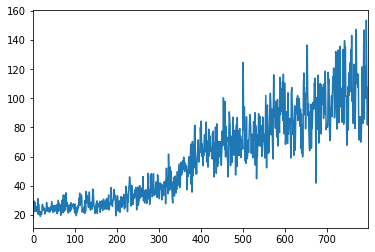

In [0]:
pd.Series(avg_returns).plot()

## Mountain Car: Non-linear function approximation and sparse rewards

### Prioritised Experience Replay

episode  0
episode  100
episode  200
episode  300


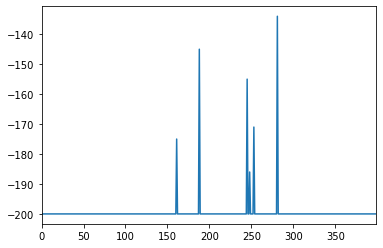

In [12]:
#%%time
# CNN seems to be too hard, try using a shallow NN using the raw state as features, the non linearaity should be able to do what the linear could not with them

# deadly triad??
# https://davidsanwald.github.io/2016/12/11/Double-DQN-interfacing-OpenAi-Gym.html

env = gym.make('MountainCar-v0')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class ANN(nn.Module):
    def __init__(self, state_dims=env.observation_space.shape[0], hs=256):
        super(ANN, self).__init__()        
        self.fc1 = nn.Linear(state_dims, hs)
        self.fc2 = nn.Linear(hs, hs)
        self.out = nn.Linear(hs, env.action_space.n) # given a state, outputs a q_value for each action

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = torch.tanh(self.fc1(x)) # https://davidsanwald.github.io/2016/12/11/Double-DQN-interfacing-OpenAi-Gym.html, https://github.com/DavidSanwald/DDQNz
        #x = torch.tanh(self.fc2(x)) # for reals tanh over rulu makes this thing work???
        return self.out(x)

from scipy.special import softmax

# taken from the pytroch tutorial 
class ReplayBuffer(object): 
    def __init__(self, capacity=5000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = [*args]
        self.position = (self.position + 1) % self.capacity # overwrite old transitions
    #def push(self, *args):        
        #if len(self.memory) < self.capacity:
        #    self.memory.append([*args])
        #else:
        #    i = np.random.choice(len(self.memory), 1, p=softmax([-abs(m[-1]) for m in self.memory]))[0] # give the highest errors the lowest pr of being replaced            
        #    self.memory[i] = [*args]
    def sample(self, batch_size, prioritise):                
        idxs = np.random.choice(len(self.memory), batch_size, p=prioritise*softmax([abs(m[-1]) for m in self.memory]) + (1-prioritise)*1/len(self.memory)) # give the highest errors more pr of being selected
        return [self.memory[i]+[i] for i in idxs]
    def __len__(self):
        return len(self.memory)
    def update_errors(self, idxs, errors):
        for i,e in zip(idxs, errors):
            self.memory[i] = self.memory[i][:-1] + [e]

# https://colab.research.google.com/drive/13Q3nTOJY9vYbhg1C0aXXIVM-IQaVVSaU#scrollTo=x--uPzWVHWPU
q_function = ANN().cuda()
q_target = ANN().cuda()
q_target.eval()
#optimiser = torch.optim.RMSprop(q_function.parameters(), lr=0.01)  ########## which one should use??
optimiser = torch.optim.Adam(q_function.parameters(), lr=0.03)
buffer = ReplayBuffer()
alpha_max, alpha_min, epsilon_max, epsilon_min = 0.2, 0.01, 0.5, 0.1
prioritise_max, prioritise_min = 1.0, 0.5
gamma = torch.Tensor([0.99]).cuda()
n_episodes = 400
bs = 64
target_update = 2
returns, losses = [], []

for n in range(n_episodes):
    if n%100==0:
        print('episode ', n)
    state = torch.Tensor(env.reset()).cuda()
    g = 0
    if n%target_update==0:
        q_target.load_state_dict(q_function.state_dict())
    while True:
        #print('g', g)
        if n < (n_episodes/2):
            #alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
            #prioritise = ((n_episodes/2) - n) * (prioritise_max - prioritise_min) / (n_episodes/2) + prioritise_min
        else:
            #alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min        
            #prioritise = ((n_episodes/2) - n%n_episodes) * prioritise_min / (n_episodes/2) + prioritise_min        
        
        #alpha = 0.01
        #epsilon = 0.1
        prioritise = 1.0

        #for param_group in optimiser.param_groups:
        #    param_group['lr'] = alpha
                
        with torch.no_grad():
            q_values = q_function(state.unsqueeze(dim=0))
        
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:          
            action = torch.argmax(q_values.squeeze()).item()         
        
        observation, reward, done, _ = env.step(action)
        #reward += abs(observation[1]) # reward shaping: add velocity to the reward to encourage movement
        observation = torch.Tensor(observation).cuda()        
        
        buffer.push(state, action, reward, observation, 1-int(done), 1000) # give high error initially to ensure this sample is selected for training at least once        
        g += reward

        if (len(buffer) >= bs):
            batch = buffer.sample(bs, prioritise)
            batch = [*zip(*batch)] # batch has idxs appended from the buffer
            states, actions, rewards, observations, dones, idxs = torch.stack(batch[0]), torch.Tensor(batch[1]).cuda().long(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]), torch.Tensor(batch[4]).cuda(), batch[6]            
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            q_values_obs = q_target(observations) 
            loss = F.smooth_l1_loss(q_values.squeeze(), rewards + gamma * torch.max(q_values_obs, dim=1).values * dones, reduction='none') # don't reduce yet, keep losses for batch error update             
            buffer.update_errors(idxs, loss.clone().detach().cpu().numpy()) # is clone required?
            loss = torch.mean(loss)
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            for param in q_function.parameters():                
                param.grad.data.clamp_(-1, 1) # help with divergence
            optimiser.step()

        if done:
            returns.append(g)
            break
        state = observation        

pd.Series(returns).plot()

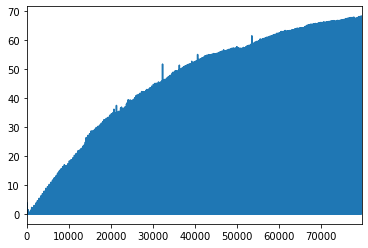

In [15]:
pd.Series(losses).plot()

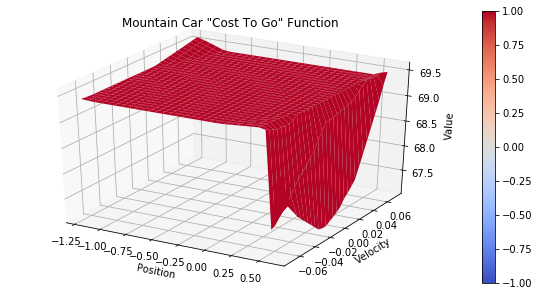

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

def plot_cost_to_go_mountain_car(num_tiles=30):
    with torch.no_grad():
        x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
        y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
        X, Y = np.meshgrid(x, y)
        Z = np.apply_along_axis(lambda s: -np.max(q_function(torch.Tensor(s).cuda()).cpu().numpy()), 2, np.dstack([X, Y]))

        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                              cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Position')
        ax.set_ylabel('Velocity')
        ax.set_zlabel('Value')
        ax.set_title("Mountain Car \"Cost To Go\" Function")
        fig.colorbar(surf)
        plt.show()

plot_cost_to_go_mountain_car()

## Junk practice code below

episode:  0 score:  0
episode:  1 score:  20.0
episode:  2 score:  10.0
episode:  3 score:  41.0
episode:  4 score:  14.0
episode:  5 score:  19.0
episode:  6 score:  25.0
episode:  7 score:  27.0
episode:  8 score:  17.0
episode:  9 score:  26.0
episode:  10 score:  17.0  average score 21.600 epsilon 0.544
episode:  11 score:  10.0
episode:  12 score:  34.0
episode:  13 score:  44.0
episode:  14 score:  39.0
episode:  15 score:  116.0
episode:  16 score:  34.0
episode:  17 score:  144.0
episode:  18 score:  93.0
episode:  19 score:  151.0
episode:  20 score:  137.0  average score 80.200 epsilon 0.022
episode:  21 score:  96.0
episode:  22 score:  102.0
episode:  23 score:  153.0
episode:  24 score:  130.0
episode:  25 score:  195.0
episode:  26 score:  174.0
episode:  27 score:  120.0
episode:  28 score:  129.0
episode:  29 score:  106.0
episode:  30 score:  130.0  average score 133.500 epsilon 0.010
episode:  31 score:  129.0
episode:  32 score:  164.0
episode:  33 score:  137.0
epis

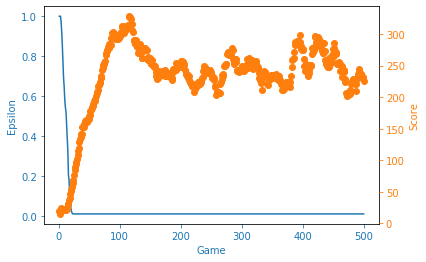

In [0]:
#https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/simple_dqn_torch.py

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, ALPHA, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=ALPHA)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')
        self.to(self.device)

    def forward(self, observation):
        state = T.Tensor(observation).to(self.device)
        #observation = observation.view(-1)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

class Agent(object):
    def __init__(self, gamma, epsilon, alpha, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.01, eps_dec=0.996):
        self.GAMMA = gamma
        self.EPSILON = epsilon
        self.EPS_MIN = eps_end
        self.EPS_DEC = eps_dec
        self.ALPHA = alpha
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.Q_eval = DeepQNetwork(alpha, n_actions=self.n_actions,
                              input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        self.state_memory = np.zeros((self.mem_size, *input_dims))
        self.new_state_memory = np.zeros((self.mem_size, *input_dims))
        self.action_memory = np.zeros((self.mem_size, self.n_actions),
                                      dtype=np.uint8)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

    def storeTransition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        actions = np.zeros(self.n_actions)
        actions[action] = 1.0
        self.action_memory[index] = actions
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = 1 - terminal
        self.mem_cntr += 1

    def chooseAction(self, observation):
        rand = np.random.random()
        actions = self.Q_eval.forward(observation)
        if rand > self.EPSILON:
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def q_function(self, state_batch):
        return self.Q_eval.forward(state_batch).to(self.Q_eval.device)

    def learn(self):
        if self.mem_cntr > self.batch_size:
            self.Q_eval.optimizer.zero_grad()

            max_mem = self.mem_cntr if self.mem_cntr < self.mem_size \
                                    else self.mem_size

            batch = np.random.choice(max_mem, self.batch_size)
            state_batch = self.state_memory[batch]
            action_batch = self.action_memory[batch].astype(np.bool_)
            action_values = np.array(self.action_space)#, dtype=np.uint8)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = self.reward_memory[batch]
            new_state_batch = self.new_state_memory[batch]
            terminal_batch = self.terminal_memory[batch]

            reward_batch = T.Tensor(reward_batch).to(self.Q_eval.device)
            terminal_batch = T.Tensor(terminal_batch).to(self.Q_eval.device)

            q_eval = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            #q_target = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            q_target = q_eval.clone()
            q_next = self.Q_eval.forward(new_state_batch).to(self.Q_eval.device)

            #batch_index = np.arange(self.batch_size, dtype=np.int32)
            #q_target[batch_index, action_indices] = reward_batch + self.GAMMA*T.max(q_next, dim=1)[0]*terminal_batch
            #print(action_batch.dtype)
            
            q_target[action_batch] = reward_batch + self.GAMMA*T.max(q_next, dim=1)[0]*terminal_batch
            #print(q_target.shape)            
            #q_target[np.vstack([batch_index, action_indices]).transpose()] = reward_batch + self.GAMMA*T.max(q_next, dim=1)[0]*terminal_batch
            
            self.EPSILON = self.EPSILON*self.EPS_DEC if self.EPSILON > self.EPS_MIN else self.EPS_MIN

            loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
            loss.backward()
            self.Q_eval.optimizer.step()

import gym
#from simple_dqn_torch import DeepQNetwork, Agent

def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

import numpy as np
from gym import wrappers

if __name__ == '__main__':
    #env = gym.make('LunarLander-v2')
    env = gym.make('CartPole-v1')
    #env = gym.make('MountainCar-v0')
    brain = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=env.action_space.n,
                  input_dims=[env.observation_space.shape[0]], alpha=0.003)

    scores = []
    eps_history = []
    num_games = 500
    score = 0
    # uncomment the line below to record every episode.
    #env = wrappers.Monitor(env, "tmp/space-invaders-1",
    #video_callable=lambda episode_id: True, force=True)
    for i in range(num_games):
        if i % 10 == 0 and i > 0:
            avg_score = np.mean(scores[max(0, i-10):(i+1)])
            print('episode: ', i,'score: ', score,
                 ' average score %.3f' % avg_score,
                'epsilon %.3f' % brain.EPSILON)
        else:
            print('episode: ', i,'score: ', score)
        eps_history.append(brain.EPSILON)
        done = False
        observation = env.reset()
        score = 0
        while not done:
            action = brain.chooseAction(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            brain.storeTransition(observation, action, reward, observation_,
                                  done)
            observation = observation_
            brain.learn()

        scores.append(score)

    x = [i+1 for i in range(num_games)]
    filename = str(num_games) + 'Games' + 'Gamma' + str(brain.GAMMA) + \
               'Alpha' + str(brain.ALPHA) + 'Memory' + \
                str(brain.Q_eval.fc1_dims) + '-' + str(brain.Q_eval.fc2_dims) +'.png'
    plotLearning(x, scores, eps_history, filename)

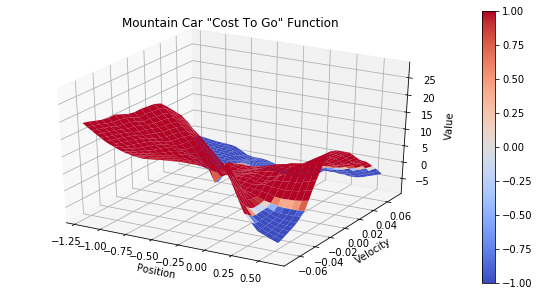

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import torch

def plot_cost_to_go_mountain_car(num_tiles=30):    
    with torch.no_grad():    
        x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
        y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
        X, Y = np.meshgrid(x, y)
        Z = np.apply_along_axis(lambda s: -np.max(brain.q_function(torch.Tensor(s).unsqueeze(dim=0)).cpu().numpy()), 2, np.dstack([X, Y]))
        
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                              cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Position')
        ax.set_ylabel('Velocity')
        ax.set_zlabel('Value')
        ax.set_title("Mountain Car \"Cost To Go\" Function")
        fig.colorbar(surf)
        plt.show()    

plot_cost_to_go_mountain_car()

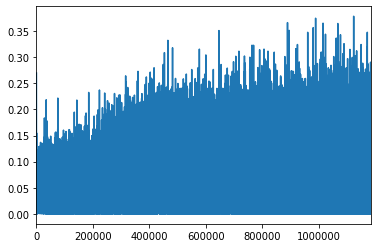

In [0]:
pd.Series(losses).plot()

episode  0
episode  25
episode  50
episode  75
episode  100
episode  125
episode  150
episode  175
episode  200
episode  225
episode  250
episode  275
episode  300
episode  325
episode  350
episode  375
episode  400
episode  425
episode  450
episode  475
episode  500
episode  525
episode  550
episode  575
episode  600
episode  625
episode  650
episode  675
episode  700
episode  725
episode  750
episode  775
episode  800
episode  825
episode  850
episode  875
episode  900
episode  925
episode  950
episode  975
episode  1000
episode  1025
episode  1050
episode  1075
episode  1100
episode  1125
episode  1150
episode  1175
episode  1200
episode  1225
episode  1250
episode  1275
episode  1300
episode  1325
episode  1350
episode  1375
episode  1400
episode  1425
episode  1450
episode  1475
episode  1500
episode  1525
episode  1550
episode  1575
episode  1600
episode  1625
episode  1650
episode  1675
episode  1700
episode  1725
episode  1750
episode  1775
episode  1800
episode  1825
episode  

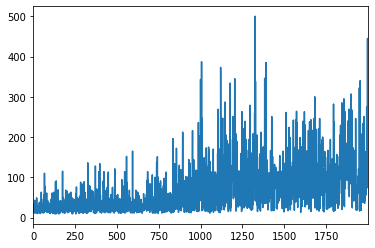

In [0]:
# deadly triad??
# https://davidsanwald.github.io/2016/12/11/Double-DQN-interfacing-OpenAi-Gym.html

import gym
#%%time
#env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')
import torch
import torch.nn as nn
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self, state_dims=env.observation_space.shape[0], hs=256):
        super(ANN, self).__init__()        
        self.fc1 = nn.Linear(state_dims, hs)
        #self.bn1 = nn.BatchNorm1d(hs)
        #self.d1 = nn.Dropout(p=.5)
        self.fc2 = nn.Linear(hs, hs)
        #self.bn2 = nn.BatchNorm1d(hs) # do I even need a second one? just reuse first?
        #self.d2 = nn.Dropout(p=.25)
        self.out = nn.Linear(hs, env.action_space.n) # given a state, outputs a q_value for each action

    def forward(self, x):
        #x = F.relu(self.d1(self.bn1(self.fc1(x))))
        #x = F.relu(self.d2(self.bn2(self.fc2(x))))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# taken from the pytroch tutorial 
class ReplayBuffer(object): 
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = [*args]
        self.position = (self.position + 1) % self.capacity # overwrite old transitions
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

q_function = ANN().cuda()
q_target = ANN().cuda()
q_target.eval()
optimiser = torch.optim.RMSprop(q_function.parameters(), lr=0.01)  ########## which one should use??
buffer = ReplayBuffer()
alpha_max, alpha_min, epsilon_max, epsilon_min = 0.1, 0.01, 0.9, 0.1
gamma = torch.Tensor([0.9]).cuda()
n_episodes = 2000
bs = 64
target_update = 10
returns,avg_returns,losses = [],[],[]
avg_returns_freq = 25

for n in range(n_episodes):
    if n%25==0:
        print('episode ', n)
    state = torch.Tensor(env.reset()).cuda()
    g = 0
    if n%target_update==0:
        q_target.load_state_dict(q_function.state_dict())
    while True:
        #print('g', g)
        if n < (n_episodes/2):
            alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
        else:
            alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min        
        
        alpha = 0.01
        #epsilon = 0.1

        #for param_group in optimiser.param_groups:
        #    param_group['lr'] = alpha
                
        q_function.eval()
        q_values = q_function(state.unsqueeze(dim=0))
        q_function.train()
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:          
            action = torch.argmax(q_values.squeeze()).item()         
        
        observation, reward, done, _ = env.step(action)
        observation = torch.Tensor(observation).cuda()        
        
        buffer.push(state, action, reward, observation, 1-int(done)) # sars
        g += reward

        if (len(buffer) >= bs): # and (frame_num%(bs*frame_skip)==0):
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations, dones = torch.stack(batch[0]), torch.Tensor(batch[1]).cuda().long(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]), torch.Tensor(batch[4]).cuda()
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            q_values_obs = q_target(observations) # using different DQN for target, these derivatives not included in SGD
            loss = F.smooth_l1_loss(q_values.squeeze(), rewards + gamma * torch.max(q_values_obs, dim=1).values * dones) # pred, targ            
            losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            for param in q_function.parameters():                
                param.grad.data.clamp_(-1, 1) # help with divergence
            optimiser.step()

        if done:
            returns.append(g)
            if n%avg_returns_freq==0:
                avg_returns.append(np.mean(returns[-avg_returns_freq:]))
            break
        state = observation        

pd.Series(returns).plot()

episode  0
episode  25
episode  50
episode  75
episode  100
episode  125
episode  150
episode  175
episode  200
episode  225
episode  250
episode  275
episode  300
episode  325
episode  350
episode  375
episode  400
episode  425
episode  450
episode  475


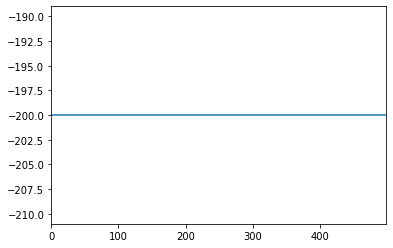

In [0]:
#%%time
# CNN seems to be too hard, try using a shallow NN using the raw state as features, the non linearaity should be able to do what the linear could not with them
env = gym.make('MountainCar-v0')
import torch
import torch.nn as nn
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self, state_dims=2, hs=100):
        super(ANN, self).__init__()        
        self.fc = nn.Linear(state_dims, hs)
        self.out = nn.Linear(hs, env.action_space.n) # given a state, outputs a q_value for each action

    def forward(self, x):        
        return self.out(F.relu(self.fc(x)))

# taken from the pytroch tutorial 
class ReplayBuffer(object): 
    def __init__(self, capacity=5000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = [*args]
        self.position = (self.position + 1) % self.capacity # overwrite old transitions
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

q_function = ANN().cuda()
q_target = ANN().cuda()
q_target.eval()
optimiser = torch.optim.RMSprop(q_function.parameters(), lr=0.01)  ########## which one should use??
buffer = ReplayBuffer()

alpha_max, alpha_min, epsilon_max, epsilon_min = 0.1, 0.01, 0.1, 0.0
gamma = torch.Tensor([0.9]).cuda()
bs = 128
n_episodes = 500
target_update = 10
returns = []
for n in range(n_episodes):
    if n%25==0:
        print('episode ', n)
    state = torch.Tensor(env.reset()).cuda()
    g = 0
    if n%target_update==0:
        q_target.load_state_dict(q_function.state_dict())
    while True:
        #print('g', g)
        if n < (n_episodes/2):
            #alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
        else:
            #alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min        
        #alpha = 0.01
        #epsilon = 0.1
        
        with torch.no_grad():
            q_values = q_function(state.unsqueeze(dim=0)) # single observation, bs is 1                
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:          
            action = torch.argmax(q_values[0]).item()         
        
        observation, reward, done, _ = env.step(action) 
        observation = torch.Tensor(observation).cuda()
        buffer.push(state, action, reward, observation) # sars
        g += reward

        if (len(buffer) >= bs):
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations = torch.stack(batch[0]), torch.Tensor(batch[1]).cuda().long(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]) # torch.Size([128, 4, 84, 84])
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            q_values_obs = q_target(observations) # using different DQN for target, these derivatives not included in SGD
            loss = F.smooth_l1_loss(q_values.squeeze(), rewards + gamma * torch.max(q_values_obs, dim=1).values) # pred, targ
            ######### is this the right loss?????
            optimiser.zero_grad()
            loss.backward()
            for param in q_function.parameters():                
                param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step() 

        if done:
            returns.append(g)
            break
        state = observation        

pd.Series(returns).plot()

In [0]:
state

tensor([-0.5222, -0.0047], device='cuda:0')

In [0]:
import gym
import time, random, math
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make('FrozenLake8x8-v0', is_slippery=True)

In [0]:
# get frames from render in notebook
# https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=RJWARWbeCUjr&forceEdit=true&sandboxMode=true
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
from gym.wrappers import Monitor
env = Monitor(gym.make("MountainCar-v0"), './video', force=True)
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
plot_durations()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

episode  0
episode  25
episode  50
episode  75
episode  100
episode  125
episode  150
episode  175
CPU times: user 2min 28s, sys: 2min 6s, total: 4min 35s
Wall time: 2min 19s


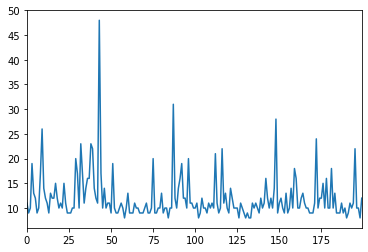

In [0]:
%%time
env = gym.make('CartPole-v1')
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import io, transform

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # use a 2d conv with 4 channels, or a 3d conv with 1?
        # copy architecture from paper: Human-level control through deep reinforcement learning
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)        
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(448*7, 512)
        self.out = nn.Linear(512, env.action_space.n) # given a state, outputs a q_value for each action
    def forward(self, x):
        #x = F.relu(self.bn1(self.conv1(x)))
        #x = F.relu(self.bn2(self.conv2(x)))
        #x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))                
        x = F.relu(self.fc(torch.flatten(x, start_dim=1))) # don't flatten batch dim
        return self.out(x)

class DQN(nn.Module):
    def __init__(self, h=84, w=84, outputs=2):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

# taken from the pytroch tutorial 
class ReplayBuffer(object): 
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = [*args]
        self.position = (self.position + 1) % self.capacity # overwrite old transitions
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

q_function = DQN().cuda()
q_target = DQN().cuda()
q_target.eval()
buffer = ReplayBuffer()
optimiser = torch.optim.RMSprop(q_function.parameters(), lr=0.01)

alpha_max, alpha_min, epsilon_max, epsilon_min = 0.1, 0.01, 0.9, 0.3
gamma = torch.Tensor([0.9]).cuda()
bs = 128
n_episodes = 200
target_update = 10
frame_skip = 4
returns = []
for n in range(n_episodes):
    if n%25==0:
        print('episode ', n)
    env.reset()
    #state = 1-(env.render(mode='rgb_array')[:,:,0]/255) # bw image
    state = env.render(mode='rgb_array')/255 
    state = transform.resize(state, (84, 84))        
    #state = torch.Tensor(np.array([state]*4)).permute([2,0,1]).cuda()    
    state = torch.Tensor(state).permute([2,0,1]).cuda()    
    g = 0
    frame_num = 0
    if n%target_update==0:
        q_target.load_state_dict(q_function.state_dict())
    while True:
        #print('g', g)
        if n < (n_episodes/2):
            #alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
        else:
            #alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min        
        #alpha = 0.01
        epsilon = 0.1

        #if frame_num%frame_skip==0:
        with torch.no_grad():
            q_values = q_function(state.unsqueeze(dim=0)) # single observation, bs is 1                
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:          
            action = torch.argmax(q_values[0]).item()         
        
        _, reward, done, _ = env.step(action) # repeat the action frame_skip times

        #observation = 1-(env.render(mode='rgb_array')[:,:,0]/255)
        #observation = torch.Tensor(transform.resize(observation, (84, 84))).cuda()
        #observation = np.concatenate([state[1:], np.expand_dims(observation, axis=0)])
        #observation = torch.cat([observation.unsqueeze(dim=0), state[:-1]]) 

        observation = env.render(mode='rgb_array')/255 
        observation = transform.resize(observation, (84, 84))        
        observation = torch.Tensor(observation).permute([2,0,1]).cuda()
        observation -= state

        #if frame_num%frame_skip==0:
        buffer.push(state, action, reward, observation) # sars

        g += reward

        if (len(buffer) >= bs): # and (frame_num%(bs*frame_skip)==0):
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations = torch.stack(batch[0]), torch.Tensor(batch[1]).cuda().long(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3])
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            q_values_obs = q_target(observations) # using different DQN for target, these derivatives not included in SGD
            loss = F.smooth_l1_loss(q_values.squeeze(), rewards + gamma * torch.max(q_values_obs, dim=1).values) # pred, targ            
            optimiser.zero_grad()
            loss.backward()
            for param in q_function.parameters():                
                param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step()

        if done:
            returns.append(g)
            break
        state = observation
        frame_num += 1

pd.Series(returns).plot()

episode  0
episode  25
episode  50
episode  75
CPU times: user 8min 19s, sys: 6min 18s, total: 14min 38s
Wall time: 7min 30s


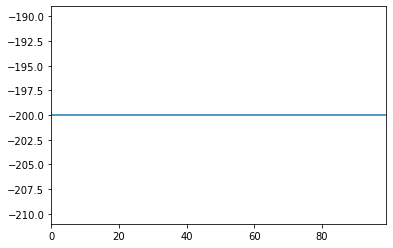

In [0]:
%%time
env = gym.make('MountainCar-v0')
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import io, transform

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # use a 2d conv with 4 channels, or a 3d conv with 1?
        # copy architecture from paper: Human-level control through deep reinforcement learning
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        #self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        #self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)        
        #self.bn3 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(448*7, 512)
        self.out = nn.Linear(512, env.action_space.n) # given a state, outputs a q_value for each action
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))                
        x = F.relu(self.fc(torch.flatten(x, start_dim=1))) # don't flatten batch dim
        return self.out(x)

# taken from the pytroch tutorial 
class ReplayBuffer(object): 
    def __init__(self, capacity=50000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = [*args]
        self.position = (self.position + 1) % self.capacity # overwrite old transitions
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

q_function = DQN().cuda()
q_target = DQN().cuda()
q_target.eval()
buffer = ReplayBuffer()
optimiser = torch.optim.RMSprop(q_function.parameters(), lr=0.1)

alpha_max, alpha_min, epsilon_max, epsilon_min = 0.1, 0.01, 0.9, 0.3
gamma = torch.Tensor([0.9]).cuda()
bs = 128
n_episodes = 500
target_update = 5
frame_skip = 4
returns = []
for n in range(n_episodes):
    if n%25==0:
        print('episode ', n)
    env.reset()
    state = 1-(env.render(mode='rgb_array')[:,:,0]/255) # bw image
    state = transform.resize(state, (84, 84))
    state = torch.Tensor(np.array([state]*4)).cuda()    
    g = 0
    frame_num = 0
    if n%target_update==0:
        q_target.load_state_dict(q_function.state_dict())
    while True:
        #print('g', g)
        if n < (n_episodes/2):
            #alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min
        else:
            #alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min
            epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min        
        #alpha = 0.01
        #epsilon = 0.1

        #if frame_num%frame_skip==0:
        with torch.no_grad():
            q_values = q_function(state.unsqueeze(dim=0)) # single observation, bs is 1                
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:          
            action = torch.argmax(q_values[0]).item()         
        
        _, reward, done, _ = env.step(action) # repeat the action frame_skip times

        observation = 1-(env.render(mode='rgb_array')[:,:,0]/255)
        observation = torch.Tensor(transform.resize(observation, (84, 84))).cuda()
        #observation = np.concatenate([state[1:], np.expand_dims(observation, axis=0)])
        observation = torch.cat([observation.unsqueeze(dim=0), state[:-1]])                

        #if frame_num%frame_skip==0:
        buffer.push(state, action, reward, observation) # sars

        g += reward

        if (len(buffer) >= bs): # and (frame_num%(bs*frame_skip)==0):
            batch = buffer.sample(bs)
            batch = [*zip(*batch)]
            states, actions, rewards, observations = torch.stack(batch[0]), torch.Tensor(batch[1]).cuda().long(), torch.Tensor(batch[2]).cuda(), torch.stack(batch[3]) # torch.Size([128, 4, 84, 84])
            #print(states.shape, actions.shape, rewards.shape, observations.shape)
            
            # update operation
            q_values = q_function(states).gather(1, actions.unsqueeze(dim=1)) # want to include this in SGD
            q_values_obs = q_target(observations) # using different DQN for target, these derivatives not included in SGD
            loss = F.smooth_l1_loss(q_values.squeeze(), rewards + gamma * torch.max(q_values_obs, dim=1).values) # pred, targ            
            optimiser.zero_grad()
            loss.backward()
            for param in q_function.parameters():                
                param.grad.data.clamp_(-1, 1) # exploding gradients?
            optimiser.step()

            

        if done:
            returns.append(g)
            break
        state = observation
        frame_num += 1

pd.Series(returns).plot()

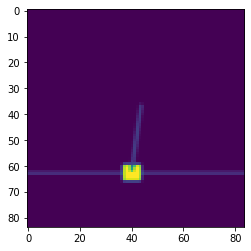

In [0]:
plt.imshow((state.cpu().numpy()*255)[0])
plt.show()

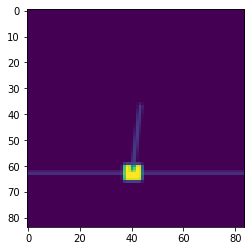

In [0]:
plt.imshow((state.cpu().numpy()*255)[1])
plt.show()

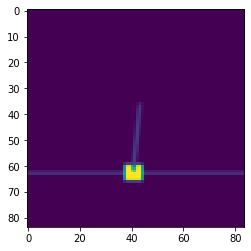

In [0]:
plt.imshow((state.cpu().numpy()*255)[2])
plt.show()

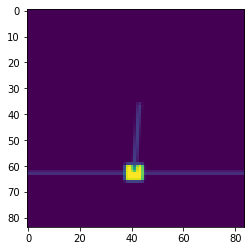

In [0]:
plt.imshow((state.cpu().numpy()*255)[-1])
plt.show()

In [0]:
state.shape

torch.Size([24, 84, 84])

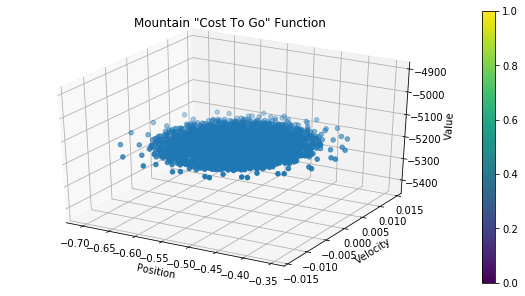

In [0]:
xs = []
ys = []
zs = []
frame_skip = 4
epsilon = 0.5
with torch.no_grad():
    for n in range(100):
        raw_state = env.reset()
        state = 1-(env.render(mode='rgb_array')[:,:,0]/255) # bw image
        state = transform.resize(state, (84, 84))
        state = torch.Tensor(np.array([state]*history_size)).cuda()    

        frame_num = 0    
        while True:
            epsilon = 0.1

            if (random.random() < epsilon):
                action = env.action_space.sample()
            else:          
                q_values = q_function(state.unsqueeze(dim=0)) # single observation, bs is 1                
                action = torch.argmax(q_values[0]).item()

            if frame_num%frame_skip==0:                
                xs.append(raw_state[0])
                ys.append(raw_state[1])
                zs.append(-(torch.max(q_values).item()))
            
            raw_state, _, done, _ = env.step(action) # repeat the action frame_skip times

            observation = 1-(env.render(mode='rgb_array')[:,:,0]/255)
            observation = torch.Tensor(transform.resize(observation, (84, 84))).cuda()
            observation = torch.cat([observation.unsqueeze(dim=0), state[:-1]])

            if done:
                break
            state = observation
            frame_num += 1

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

def plot_cost_to_go_mountain_car(num_tiles=30):
    #x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    #y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    #X, Y, Z = np.array([xs]), np.array([ys]), np.array([zs])
    X, Y, Z = np.array(xs), np.array(ys), np.array(zs)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')    
    surf = ax.scatter(X, Y, Z, #rstride=1, cstride=1, 
                      #c = np.expand_dims(Z, axis=2),
                           cmap=matplotlib.cm.coolwarm, vmin=-10.0, vmax=10.0)
    
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()

plot_cost_to_go_mountain_car()

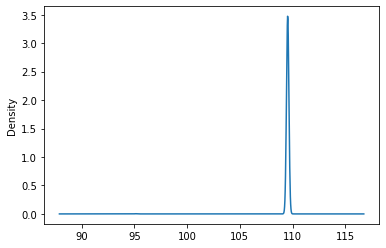

In [0]:
pd.Series(zs).plot.density()

In [0]:
zs

[95.11409759521484,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.53093719482422,
 109.530937194

CPU times: user 3min 34s, sys: 55.8 ms, total: 3min 34s
Wall time: 3min 34s


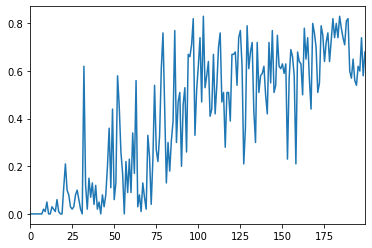

In [0]:
%%time
q_values = np.zeros((2,env.observation_space.n, env.action_space.n)) # double q learning: extra dimension for Q1 and Q2
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 1.0, 0.1, 0.9, 0.9, 0.1
n_episodes = 200000
avg_wins = []
# q-learning because action = max(actions)
for n in range(n_episodes):
    env.reset()
    state = 0
    if n < (n_episodes/2):
        alpha = ((n_episodes/2) - n) * (alpha_max - alpha_min) / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n) * (epsilon_max - epsilon_min) / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    else:
        alpha = ((n_episodes/2) - n%n_episodes) * alpha_min / (n_episodes/2) + alpha_min # decreasing linear schedule   
        epsilon = ((n_episodes/2) - n%n_episodes) * epsilon_min / (n_episodes/2) + epsilon_min # decreasing linear schedule   
    while True:
        update = int(random.random() < 0.5)
        if (random.random() < epsilon):
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[update, state])
        observation, reward, done, info = env.step(action)
        # update operation                
        q_sa = q_values[update, state, action]
        # reduce maximisation bias by using a second network to pick next max action
        next_action = np.argmax(q_values[1-update, observation]) # off policy because this is a greedy policy action selection        
        q_values[update, state, action] = q_sa + alpha * (reward + gamma * q_values[1-update, observation, next_action] - q_sa)
        state = observation        
        if done: 
            #if reward==1:
            #    print('win')
            break
    if n%1000==0: # diagnostic
        avg_wins.extend([rate_policy(env, q_values[0])])        
#env.close()
pd.Series(avg_wins).plot()

CPU times: user 2min 34s, sys: 85 ms, total: 2min 34s
Wall time: 2min 34s


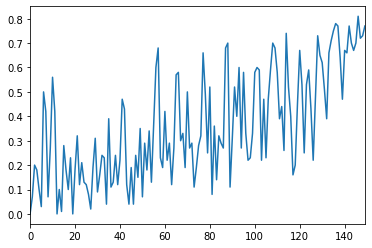

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.5, 0.1, 0.9, 0.9, 0.0
n_episodes = 150000
avg_wins = []
# q-learning because action = max(actions)
for n in range(n_episodes):
    env.reset()
    state = 0
    alpha = (n_episodes - n) * (alpha_max - alpha_min) / n_episodes # decreasing linear schedule   
    epsilon = (n_episodes - n) * (epsilon_max - epsilon_min) / n_episodes # decreasing linear schedule   
    while True:
        if (random.random() < epsilon): # or (np.sum(q_values[state])==0): # e-greedy, 2nd conditional greatly speeds up training
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # update operation        
        q_sa = q_values[state, action]
        next_action = np.argmax(q_values[observation]) # off policy because this is a greedy policy action selection        
        q_values[state, action] = q_sa + alpha * (reward + gamma * q_values[observation, next_action] - q_sa)
        state = observation        
        if done: 
            #if reward==1:
            #    print('win')
            break
    if n%1000==0: # diagnostic
        avg_wins.extend([rate_policy(env, q_values)])        
#env.close()
pd.Series(avg_wins).plot()

CPU times: user 2min 53s, sys: 22.8 ms, total: 2min 53s
Wall time: 2min 53s


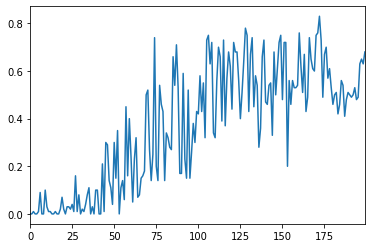

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
#alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.5, 0.1, 0.9, 0.9, 0.0
alpha_start, alpha = 0.9, 0.9
epsilon_start, epsilon = 0.9, 0.9
decay = 0.0001
gamma = 0.9
n_episodes = 200000
avg_wins = []
# q-learning because action = max(actions)
for n in range(n_episodes):
    env.reset()
    state = 0    
    while True:
        if (random.random() < epsilon): # e-greedy
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # update operation        
        q_sa = q_values[state, action]
        next_action = np.argmax(q_values[observation]) # off policy because this is a greedy policy action selection        
        q_values[state, action] = q_sa + (0.1 + alpha) * (reward + gamma * q_values[observation, next_action] - q_sa)
        state = observation        
        if done: 
            #if reward==1:
            #    print('win')
            break
    alpha *= 1.0 / (1 + (decay / n_episodes) * n)
    epsilon *= 1.0 / (1 + (decay / n_episodes) * n)    
    if n%1000==0: # diagnostic
        avg_wins.extend([rate_policy(env, q_values)])        
#env.close()
pd.Series(avg_wins).plot()

CPU times: user 8min 39s, sys: 1.12 s, total: 8min 40s
Wall time: 8min 39s


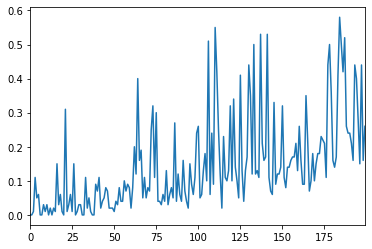

In [0]:
%%time
from scipy.special import softmax
q_values = np.zeros((env.observation_space.n, env.action_space.n))
#alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.5, 0.1, 0.9, 0.9, 0.0
alpha,epsilon = 0.9,0.9
decay = 0.0001
gamma = 0.9
n_episodes = 200000
avg_wins = []
# q-learning because action = max(actions)
for n in range(n_episodes):
    env.reset()
    state = 0    
    while True:
        if (random.random() < epsilon): # e-greedy
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # update operation        
        q_sa = q_values[state, action]
        #observation_expected_q = np.mean(q_values[observation]) # expected sarsa
        observation_expected_q = np.sum(softmax(q_values[observation]) * q_values[observation]) # expected sarsa # expected sarsa
        q_values[state, action] = q_sa + (0.1 + alpha) * (reward + gamma * observation_expected_q - q_sa)
        state = observation        
        if done: 
            #if reward==1:
            #    print('win')
            break
    alpha *= 1.0 / (1 + (decay / n_episodes) * n)
    epsilon *= 1.0 / (1 + (decay / n_episodes) * n)    
    if n%1000==0: # diagnostic
        avg_wins.extend([rate_policy(env, q_values)])        
#env.close()
pd.Series(avg_wins).plot()

CPU times: user 9min 21s, sys: 193 ms, total: 9min 21s
Wall time: 9min 21s


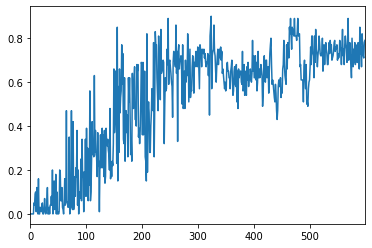

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
#alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.5, 0.1, 0.9, 0.9, 0.0
alpha_start, alpha = 0.9, 0.9
epsilon_start, epsilon = 0.9, 0.9
decay = 0.0001
gamma = 0.9
n_episodes = 600000
avg_wins = []
# q-learning because action = max(actions)
for n in range(n_episodes):
    env.reset()
    state = 0    
    while True:
        if (random.random() < epsilon): # e-greedy
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # update operation        
        q_sa = q_values[state, action]
        next_action = np.argmax(q_values[observation]) # off policy because this is a greedy policy action selection        
        q_values[state, action] = q_sa + (0.1 + alpha) * (reward + gamma * q_values[observation, next_action] - q_sa)
        state = observation        
        if done: 
            #if reward==1:
            #    print('win')
            break
    alpha *= 1.0 / (1 + (decay / n_episodes) * n)
    epsilon *= 1.0 / (1 + (decay / n_episodes) * n)    
    if n%1000==0: # diagnostic
        avg_wins.extend([rate_policy(env, q_values)])        
#env.close()
pd.Series(avg_wins).plot()

In [0]:
%%time

#alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.5, 0.1, 0.9, 0.9, 0.0
alpha_start, alpha = 1.0, 1.0
epsilon_start, epsilon = 0.9, 0.9
decay = 0.001
gamma = 0.9
n_episodes = 15000
eps, alphs = [], []
# q-learning because action = max(actions)
for n in range(n_episodes):
    env.reset()
    state = 0    
    eps.append(epsilon)
    alphs.append(alpha)
    alpha *= 1.0 / (1 + (decay / n_episodes) * n)
    epsilon *= 1.0 / (1 + (decay / n_episodes) * n)    

CPU times: user 193 ms, sys: 53.1 ms, total: 246 ms
Wall time: 175 ms


(1.0, 0.00675930627956606)

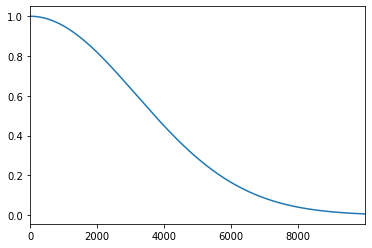

In [0]:
# Scheduler
alpha = 1.0
n_episodes = 10000
alphas = []
alpha_decay = 0.001
for n in range(n_episodes):
    alphas.extend([alpha])
    alpha *= 1.0 / (1 + (alpha_decay / n_episodes) * n)
pd.Series(alphas).plot()
alphas[0], alphas[-1]

(1.0, 0.0005552999913213917)

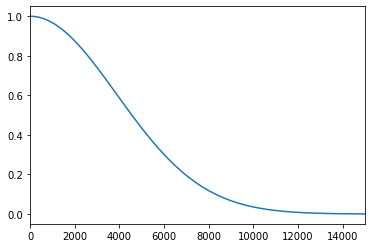

In [0]:
pd.Series(alphs).plot()
alphs[0], alphs[-1]

(0.9, 0.0004997699921892527)

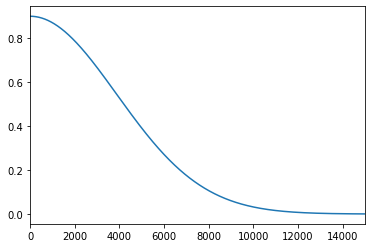

In [0]:
pd.Series(eps).plot()
eps[0], eps[-1]

CPU times: user 4min 15s, sys: 21.8 ms, total: 4min 15s
Wall time: 4min 16s


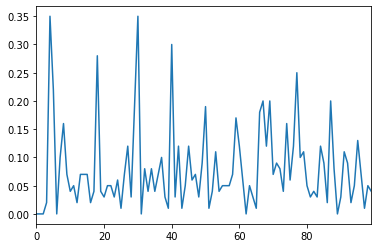

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.5, 0.1, 0.9, 0.1, 0.0
n_episodes = 100000
avg_wins = []
from scipy.special import softmax # expected sarsa
for n in range(n_episodes):
    env.reset()
    state = 0
    alpha = .5 #(n_episodes - n) * (alpha_max - alpha_min) / n_episodes # decreasing linear schedule   
    epsilon = .8 #(n_episodes - n) * (epsilon_max - epsilon_min) / n_episodes # decreasing linear schedule   
    while True:
        if (random.random() < epsilon): # or (np.sum(q_values[state])==0): # e-greedy, 2nd conditional greatly speeds up training
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        """# actual action (slippery)      
        if (observation + 1) == state: # left
            action = 0
        elif (observation - 1) == state: # right
            action = 2
        elif (observation - 8) == state: # down
            action = 1
        elif (observation + 8) == state: # up
            action = 3        
        #if observation != state:  # if no movement, don't update          
        """
        # update operation        
        #if done:
        #    q_values[observation] = np.zeros(env.nA)    
        q_sa = q_values[state, action] #.copy()
        observation_expected_q = np.sum(softmax(q_values[observation]) * q_values[observation]) # expected sarsa
        q_values[state, action] = q_sa + alpha * (reward + gamma * observation_expected_q - q_sa)
        state = observation        
        if done:              
            break
    if n%1000==0: # diagnostic
        avg_wins.extend([rate_policy(env, q_values)])        
#env.close()
pd.Series(avg_wins).plot()

CPU times: user 3min 48s, sys: 393 ms, total: 3min 49s
Wall time: 3min 48s


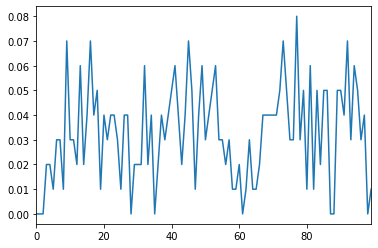

In [0]:
%%time
q_values = np.zeros((env.observation_space.n, env.action_space.n))
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.5, 0.1, 0.9, 0.1, 0.0
n_episodes = 100000
avg_wins = []
from scipy.special import softmax # expected sarsa
for n in range(n_episodes):
    env.reset()
    state = 0
    alpha = .5 #(n_episodes - n) * (alpha_max - alpha_min) / n_episodes # decreasing linear schedule   
    epsilon = .8 #(n_episodes - n) * (epsilon_max - epsilon_min) / n_episodes # decreasing linear schedule   
    while True:
        if (random.random() < epsilon): # or (np.sum(q_values[state])==0): # e-greedy, 2nd conditional greatly speeds up training
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # actual action (slippery)      
        if (observation + 1) == state: # left
            action = 0
        elif (observation - 1) == state: # right
            action = 2
        elif (observation - 8) == state: # down
            action = 1
        elif (observation + 8) == state: # up
            action = 3        
        #if observation != state:  # if no movement, don't update                  
        # update operation        
        #if done:
        #    q_values[observation] = np.zeros(env.nA)    
        q_sa = q_values[state, action] #.copy()
        observation_expected_q = np.sum(softmax(q_values[observation]) * q_values[observation]) # expected sarsa
        q_values[state, action] = q_sa + alpha * (reward + gamma * observation_expected_q - q_sa)
        state = observation        
        if done:              
            break
    if n%1000==0: # diagnostic
        avg_wins.extend([rate_policy(env, q_values)])        
#env.close()
pd.Series(avg_wins).plot()

CPU times: user 2min, sys: 28.9 ms, total: 2min
Wall time: 2min


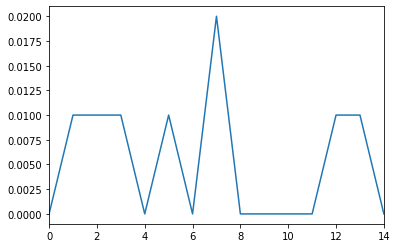

In [0]:
%%time
#q_values = np.zeros((env.observation_space.n, env.action_space.n)) # this bad?
#q_values = np.random.rand(env.observation_space.n, env.action_space.n) / 1000 # make terminal states 0
alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 0.5, 0.1, 0.9, 0.0, 0.0
n_episodes = 300000
avg_wins = []
# q-learning because action = max(actions)
for n in range(n_episodes):
    env.reset()
    state = 0
    alpha = .5 #(n_episodes - n) * (alpha_max - alpha_min) / n_episodes # decreasing linear schedule   
    epsilon = 0.25 #(n_episodes - n) * (epsilon_max - epsilon_min) / n_episodes # decreasing linear schedule   
    while True:
        if (random.random() < epsilon): # or (np.sum(q_values[state])==0): # e-greedy, 2nd conditional greatly speeds up training
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state])
        observation, reward, done, info = env.step(action)
        # actual action (slippery)      
        if (observation + 1) == state: # left
            action = 0
        elif (observation - 1) == state: # right
            action = 2
        elif (observation - 8) == state: # down
            action = 1
        elif (observation + 8) == state: # up
            action = 3        
        #if observation != state:  # if no movement, don't update          
        # update operation        
        #if done:
        #    q_values[observation] = np.zeros(env.nA)    
        q_sa = q_values[state, action] #.copy()
        next_action = np.argmax(q_values[observation]) # off policy because this is a greedy policy action selection        
        q_values[state, action] = q_sa + alpha * (reward + gamma * q_values[observation, next_action] - q_sa)
        state = observation        
        if done:              
            break
    if n%20000==0: # diagnostic
        avg_wins.extend([rate_policy(env, q_values)])        
#env.close()
pd.Series(avg_wins).plot()

In [0]:
q_values

array([[0.17310119, 0.19627907, 0.19596928, 0.17395105],
       [0.17736727, 0.22223536, 0.22220222, 0.20035177],
       [0.20157662, 0.24690073, 0.2447653 , 0.22280266],
       [0.2246759 , 0.27428525, 0.27263579, 0.24755591],
       [0.24993338, 0.30480873, 0.30056566, 0.27547994],
       [0.27483039, 0.3373905 , 0.33690375, 0.30483752],
       [0.30649377, 0.37466574, 0.29454417, 0.33414207],
       [0.31920708, 0.32028791, 0.28753374, 0.293764  ],
       [0.20063043, 0.21977247, 0.22223621, 0.17794383],
       [0.20014691, 0.24676425, 0.24690789, 0.20002648],
       [0.22248644, 0.27414558, 0.27429791, 0.22224669],
       [0.24708754, 0.        , 0.3047242 , 0.24689559],
       [0.27437156, 0.3385062 , 0.33713055, 0.27569377],
       [0.30485349, 0.37467226, 0.37457673, 0.30614373],
       [0.33730466, 0.41618084, 0.34003758, 0.33913033],
       [0.37453964, 0.37221079, 0.33774632, 0.29509306],
       [0.2221144 , 0.24607942, 0.24677142, 0.20475905],
       [0.22210998, 0.27416017,

In [0]:
q_values = np.array([[0.00000000e+00, 2.54186583e-01, 2.54186583e-01, 0.00000000e+00],
       [2.28767925e-01, 2.82429536e-01, 2.82429536e-01, 0.00000000e+00],
       [2.54186583e-01, 3.13810596e-01, 3.13810596e-01, 0.00000000e+00],
       [2.82429536e-01, 3.48678440e-01, 3.48678440e-01, 0.00000000e+00],
       [3.13810596e-01, 3.87420489e-01, 3.87420489e-01, 0.00000000e+00],
       [3.48678440e-01, 4.30467210e-01, 4.30467210e-01, 0.00000000e+00],
       [3.87420489e-01, 4.78296900e-01, 4.78296900e-01, 0.00000000e+00],
       [4.30467210e-01, 5.31441000e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.28767925e-01, 2.82429536e-01, 2.28767925e-01],
       [1.95593824e-02, 2.54186583e-01, 3.13810596e-01, 2.54186583e-01],
       [2.41773407e-02, 2.82429536e-01, 3.48678440e-01, 2.82429536e-01],
       [6.54510282e-05, 0.00000000e+00, 3.87420489e-01, 3.13810596e-01],
       [3.48678440e-01, 4.30467210e-01, 4.30467210e-01, 3.48678440e-01],
       [3.87420489e-01, 4.78296900e-01, 4.78296900e-01, 3.87420489e-01],
       [4.30467210e-01, 5.31441000e-01, 5.31441000e-01, 4.30467203e-01],
       [4.78296900e-01, 5.90490000e-01, 0.00000000e+00, 4.38337417e-02],
       [0.00000000e+00, 2.05891132e-01, 2.54186583e-01, 2.54186583e-01],
       [2.28767925e-01, 2.28767925e-01, 2.82429536e-01, 2.82429536e-01],
       [2.54186583e-01, 4.45410166e-03, 0.00000000e+00, 3.13810596e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.87420489e-01, 4.78296900e-01, 3.87420489e-01],
       [0.00000000e+00, 0.00000000e+00, 5.31441000e-01, 4.30467210e-01],
       [4.78296900e-01, 5.90490000e-01, 5.90490000e-01, 4.78296900e-01],
       [5.31441000e-01, 6.56100000e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.85302019e-01, 2.28767925e-01, 2.28767925e-01],
       [2.05891132e-01, 2.05891132e-01, 2.54186583e-01, 2.54186583e-01],
       [2.28767925e-01, 0.00000000e+00, 2.28767925e-01, 2.82429536e-01],
       [2.54186583e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.28767925e-01, 0.00000000e+00, 0.00000000e+00, 4.30467210e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.56100000e-01, 6.56100000e-01, 5.31441000e-01],
       [5.90490000e-01, 7.29000000e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.66771817e-01, 2.05891132e-01, 2.05891132e-01],
       [1.85302019e-01, 0.00000000e+00, 2.28767925e-01, 2.28767925e-01],
       [2.05891132e-01, 0.00000000e+00, 0.00000000e+00, 2.54186583e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.91063693e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 7.29000000e-01, 5.90490000e-01],
       [6.56100000e-01, 8.10000000e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.85302019e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.00000000e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

Use TD(0) for prediction (state value learning) and sarsa for on-policy control

In [0]:
env = gym.make('FrozenLake8x8-v0', is_slippery=True)
q_values = np.zeros((env.observation_space.n, env.action_space.n))

CPU times: user 7min 9s, sys: 133 ms, total: 7min 9s
Wall time: 7min 9s


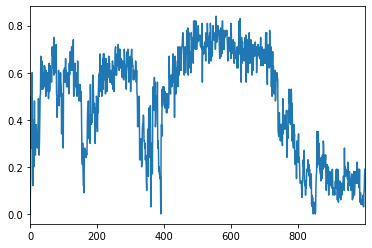

In [0]:
%%time
render = False
alpha, gamma, epsilon_max, epsilon_min = 0.1, 0.9, 0.0, 0.00 
n_episodes = 100000
avg_wins = []
# sarsa: actually is q-learning because action = max(actions)
for n in range(n_episodes):
    env.reset()
    state,t,g = 0,0,0
    epsilon = (n_episodes - n) * (epsilon_max - epsilon_min) / n_episodes    
    while True:
        if (random.random() < epsilon) or (np.sum(q_values[state])==0): # e-greedy
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state]) 
        observation, reward, done, info = env.step(action)    
        t+=1
        g+=reward
        if render:
            env.render()
            time.sleep(.5)
            clear_output()
        if done and reward==0: # penalise for falling in hole
            reward = -1
        # update operation
        #print(q_values[state, action], q_values[observation, next_action])
        q_sa = q_values[state, action]
        next_action = np.argmax(q_values[observation])
        #print(alpha * (reward + gamma * q_values[observation, next_action] - q_sa))
        q_values[state, action] = q_sa + alpha * (reward + gamma * q_values[observation, next_action] - q_sa)
        state = observation
        #print(q_values[state, action])
        #asdad
        if done:
            #if g>0:
                #wins+=1
            #    print('winner')
            #print("Episode finished after {} timesteps with a return of {}".format(t, g))
            break
    if n%100==0: # diagnostic
        avg_wins.extend([rate_policy(env, q_values)])        
env.close()
pd.Series(avg_wins).plot()

In [0]:
env.reset()
state = 0
while True:
    action = np.argmax(q_values[state])
    state, reward, done, _ = env.step(action)
    print(state)
    env.render()
    time.sleep(2.5)
    if done:
        break
    clear_output()    

49
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [0]:
env = gym.make('FrozenLake8x8-v0', is_slippery=True)
q_values = np.zeros((env.observation_space.n, env.action_space.n))

CPU times: user 17min 3s, sys: 512 ms, total: 17min 4s
Wall time: 17min 4s


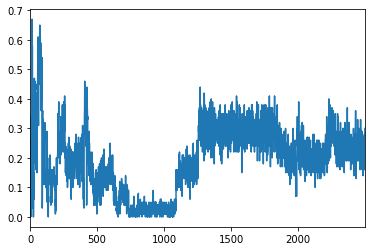

In [0]:
%%time
render = False
alpha, gamma, epsilon_max, epsilon_min = 0.1, 0.9, 0.0, 0.00 
n_episodes = 250000
avg_wins = []
# sarsa: actually is q-learning because action = max(actions)
for n in range(n_episodes):
    env.reset()
    state,t,g = 0,0,0
    epsilon = (n_episodes - n) * (epsilon_max - epsilon_min) / n_episodes    
    while True:
        if (random.random() < epsilon) or (np.sum(q_values[state])==0): # e-greedy
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values[state]) 
        observation, reward, done, info = env.step(action)    
        t+=1        
        if done and reward==0: # penalise for falling in hole
            reward = -99
        else:
            reward = -1
        g+=reward
        if render:
            env.render()
            time.sleep(.5)
            clear_output()        
        # update operation
        #print(q_values[state, action], q_values[observation, next_action])
        q_sa = q_values[state, action]
        next_action = np.argmax(q_values[observation])
        #print(alpha * (reward + gamma * q_values[observation, next_action] - q_sa))
        if done and reward==1:
            q_values[state, action] = q_sa + alpha * (reward - q_sa)
        else:
            q_values[state, action] = q_sa + alpha * (reward + gamma * q_values[observation, next_action] - q_sa)
        state = observation
        #print(q_values[state, action])
        #asdad
        if done:
            #if g>0:
                #wins+=1
            #    print('winner')
            #print("Episode finished after {} timesteps with a return of {}".format(t, g))
            break
    if n%100==0: # diagnostic
        wins = 0
        for _ in range(100):
            env.reset()
            state = 0
            while True:
                action = np.argmax(q_values[state])
                state, reward, done, _ = env.step(action)
                if done:
                    if reward==1:
                        wins+=1
                    break
        avg_wins.extend([wins/100])
env.close()
pd.Series(avg_wins).plot()

In [0]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(q_values)

[[0.23 0.25 0.21 0.23]
 [0.23 0.03 0.04 -0.02]
 [0.02 0.31 0.00 0.03]
 [0.00 0.00 0.35 0.03]
 [0.00 0.39 0.03 0.14]
 [0.16 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.25 0.23 0.28 0.23]
 [0.25 0.25 0.31 0.21]
 [0.28 0.28 0.35 0.28]
 [0.31 -1.00 0.39 0.31]
 [0.35 0.43 0.35 0.35]
 [0.39 0.00 0.00 0.01]
 [0.03 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.21 0.15 0.25 0.18]
 [0.22 0.21 0.28 0.25]
 [0.22 0.18 -1.00 0.31]
 [0.00 0.00 0.00 0.00]
 [-1.00 0.48 0.39 0.39]
 [0.43 -0.47 0.00 0.03]
 [0.02 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [0.02 0.00 0.21 0.02]
 [0.01 -0.00 0.03 0.25]
 [0.01 -0.05 0.05 0.28]
 [0.25 -0.75 -0.02 -0.57]
 [0.23 0.53 -1.00 0.43]
 [0.00 0.00 0.00 0.00]
 [-0.19 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [-0.03 -0.03 -0.00 0.04]
 [0.00 -1.00 -0.10 -0.09]
 [-0.00 -1.00 -1.00 0.00]
 [0.00 0.00 0.00 0.00]
 [-1.00 0.59 0.48 0.48]
 [0.53 0.18 0.00 -0.47]
 [0.04 -0.10 0.00 0.00]
 [0.00 0.00 0.00 0.00]
 [-0.07 -0.09 -0.83 0.00]
 [0.00 0.00 0.00 0.00]
 [0.00 

## Deep Reinforcement Learning Algorithms

In [0]:
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

#import math
#import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#from collections import namedtuple
#from itertools import count
#from PIL import Image

In [0]:
print(torch.__version__)
print(sys.version)

1.3.1
3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


In [0]:
env = gym.make('CartPole-v0') #.unwrapped

In [0]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
import gym
env = gym.make('CartPole-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

C:\Users\Callum\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


[-0.02231942  0.04224469 -0.04278855  0.0300786 ]
[-0.02147453 -0.15223836 -0.04218698  0.30896017]
[-0.02451929 -0.34673462 -0.03600778  0.58804569]
[-0.03145398 -0.15112741 -0.02424686  0.28424106]
[-0.03447653  0.04433183 -0.01856204 -0.01598949]
[-0.0335899   0.23971499 -0.01888183 -0.31447068]
[-0.0287956   0.04486703 -0.02517125 -0.02780176]
[-0.02789826  0.24034074 -0.02572728 -0.32831901]
[-0.02309144  0.43581933 -0.03229366 -0.62900284]
[-0.01437505  0.63137672 -0.04487372 -0.93167867]
[-0.00174752  0.82707455 -0.06350729 -1.23811837]
[ 0.01479397  0.63282328 -0.08826966 -0.96598744]
[ 0.02745044  0.43899064 -0.10758941 -0.70228803]
[ 0.03623025  0.6354263  -0.12163517 -1.02680808]
[ 0.04893878  0.83193902 -0.14217133 -1.3550719 ]
[ 0.06557756  0.63885846 -0.16927277 -1.11003085]
[ 0.07835472  0.44631534 -0.19147338 -0.87487292]
[ 0.08728103  0.25423966 -0.20897084 -0.64797453]
Episode finished after 18 timesteps
[ 0.04870411 -0.00668981 -0.00245215  0.04270024]
[ 0.04857031  

KeyboardInterrupt: 

In [0]:
import gym
env = gym.make('CartPole-v0')
print(env.action_space)
#> Discrete(2)
print(env.observation_space)
#> Box(4,)

Discrete(2)
Box(4,)


## Dynamic Programming

#### Tabular Methods, State Space and Policy Definition

Dynamic Programming (DP) solutions to RL problems are typically applied only to finite MDPs and as such the observation space of the CartPole envrionment will need to be quantised to create a discrete state space.

In [0]:
import gym
env = gym.make('CartPole-v0')
print(env.observation_space)
print(env.observation_space.low) # dims 2 and 4 are ~= -inf
print(env.observation_space.high) # dims 2 and 4 are ~= +inf

Box(4,)
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


C:\Users\Callum\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


The state space of the CartPole environment is an unbounded continuous four dimensional box, possibly representing the agent's vertical and horizontal position, and vertical and horizontal velocity. In order to use a tabular solution method, the state space must be quantised and bounded to a discrete size that is tractable when solving.

In [0]:
import numpy as np
def quantise(observation):
    q, lb, ub = 0.1, -1, 1
    return np.clip(np.clip(q * np.round(observation / q), env.observation_space.low, env.observation_space.high), lb, ub)

sample = env.observation_space.sample()
print(sample, '\n', quantise(sample))

[ 4.4425955e+00 -3.2880009e+38  1.6460474e-01  2.1347861e+38] 
 [ 1.  -1.   0.2  1. ]


C:\Users\Callum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in true_divide
  after removing the cwd from sys.path.


Given a quantising step of 0.1 and upper and lower bounds of -1 and 1 respectively, the number of discrete states in the environment is:

In [0]:
np.prod((quantise(env.observation_space.high) - quantise(env.observation_space.low)) / 0.1)

C:\Users\Callum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in true_divide
  after removing the cwd from sys.path.


64000.0

In [0]:
And given that the cardinality of the action space is 2, a tabular policy will consist of twice that number of rows.

It seems like a poor choice to use a tabular method to solve this 
Let's investigate how well tabular methods can solve this problem.

#### Reward Signal

We will treat this as an episodic task, where the episode ends either when the pole falls below a certain angle or the cart runs off the screen. The reward signal is defined by the environment as +1 for every time step which does not result in failure, the total number of time steps in the episode. The return for an episode is given simply as:

In [0]:
observation = env.reset()
t=0
while True:    
    env.render()
    action = env.action_space.sample() # take a random action for now
    observation, reward, done, info = env.step(action)    
    t+=1
    if done:
        print("Episode finished after {} timesteps with a return of {}".format(t+1, t))
        break
env.close()

[-0.0059521   0.24203671 -0.04858317 -0.30948833]
[-0.00111136  0.437816   -0.05477294 -0.61708859]
[ 0.00764496  0.24350027 -0.06711471 -0.34214731]
[ 0.01251496  0.04939418 -0.07395766 -0.07136058]
[ 0.01350284  0.24549422 -0.07538487 -0.38643028]
[ 0.01841273  0.44160085 -0.08311347 -0.70189694]
[ 0.02724475  0.24772325 -0.09715141 -0.43649167]
[ 0.03219921  0.44407654 -0.10588125 -0.75815035]
[ 0.04108074  0.64048588 -0.12104425 -1.08218542]
[ 0.05389046  0.83697928 -0.14268796 -1.41026911]
[ 0.07063004  0.64388581 -0.17089334 -1.16538048]
[ 0.08350776  0.45134939 -0.19420095 -0.93078125]
[ 0.09253475  0.25930329 -0.21281658 -0.70486404]
Episode finished after 14 timesteps with a return of 13


#### Value Function

#### Policy Iteration:
* Policy Evaluation
* Policy Improvement

#### Value Iteration:

In [0]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback